In [ ]:
import numpy as np # using version 1.22.4 as the newer version unsuitable for stable baselines 3
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import math
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

In [ ]:
## Rastrigin Function and its directional derivatives

def ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose 

    res = np.linalg.norm( A@cord - B )
    res = 0.5 * (res ** 2)

    angle = np.array(2 * math.pi * cord)
    tri = C@np.cos(angle)

    res = res - tri + n
  
    return res[0][0]


def grad_ras(cord, A, B, C):
    n = cord.shape[0]
    cord = np.atleast_2d(cord).T  #Transpose 

    Anew = A.copy()
    res = Anew@cord - B

    res = np.append(res, [[2 * math.pi]])
  
    tri = np.sin(2 * math.pi * cord)
  
    a = C@tri
  
    val = np.full((n, 1), a[0][0])
  
    Anew = np.hstack((Anew, val))
 
    res = Anew@res
  
    return res

In [20]:
# Parameters

n = 3  # Number of dimensions of the function

# Observation space limits
HIGH = 10000
LOW = -10000

# Limits of the area in which initialization will take place
INIT_HIGH = 30 
INIT_LOW = -30

PREV = 25 # number of previous iterates to consider as states

MAX_STEP = 100 # maximum number of steps per episode, trancation if still not converged

COUNTER = 100 # maximum number of episodes for a set of parameters

# Initialization of the A,B,C parameters of the Rastrigan-like function
A = np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32)
B = np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32)
C = np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32)

TOLERANCE = 1e-5 # if the change is lower than this then the episode will terminate

BOUNDARY_PENALTY = -10000 # reward if point goes outside the boundary
MAX_GRADIENT = 10000

In [21]:
# Custom environment

class L2O_RL(gym.Env):
    
    def __init__(self, n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT):
        super(L2O_RL, self).__init__()
        
        # Variables
        self.n = n
        self.dim = n*PREV
        
        self.high = HIGH
        self.low = LOW
        self.init_high = INIT_HIGH
        self.init_low = INIT_LOW
        
        self.step_no = 0
        self.max_step = MAX_STEP
        self.counter = COUNTER
        self.max_counter = COUNTER
        
        self.A = A
        self.B = B
        self.C = C
        
        self.tolerance = TOLERANCE
        self.boundary_penalty = BOUNDARY_PENALTY
        self.max_gradient = MAX_GRADIENT
    
        # Spaces
        self.observation_space = spaces.Box(low = LOW, high = HIGH, shape=(self.dim,), dtype = np.float32)
        self.action_space = spaces.Box(low = LOW, high = HIGH, shape=(self.n,), dtype = np.float32)
        
        # State
        self.cord = np.random.uniform(self.init_low, self.init_high, self.n) # Random Initialization of the starting point
        self.dq = deque(np.zeros(self.dim, dtype = np.float32))
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # Gradient at that point
        
        for i in range(self.n):
            self.dq.pop()
        self.dq.extendleft(np.flip(self.grad))
        #self.dq.extendleft(np.flip(self.cord))
        
        self.observation = np.array(self.dq, dtype = np.float32)
        
    def step(self, action):
        self.cord = self.cord + action
        
        self.grad = grad_ras(self.cord, self.A, self.B, self.C) # gradient at the new coordinates
        
        terminated = False
        truncated = False
        info = {}
        
        boundary_flag = False
        
        # check if the coordinates are out of the limits
        for i in range(self.n):
            if self.cord[i] > self.high:
                boundary_flag = True
                self.cord[i] = np.float32(self.high)
                
            elif self.cord[i] < self.low:
                boundary_flag = True
                self.cord[i] = np.float32(self.low)
       
        # check if the gradients are out of the limits
        for i in range(self.n):
            self.grad[i] = min(self.grad[i], self.max_gradient)
            self.grad[i] = max(self.grad[i], (-1*self.max_gradient))
        
        # calculate observation
        for i in range(self.n):
            self.dq.pop()
        self.dq.extendleft(np.flip(self.grad))
        #self.dq.extendleft(np.flip(self.cord))
        self.observation = np.array(self.dq, dtype = np.float32)
        
        # truncate if more than max number of steps
        self.step_no = self.step_no + 1
        if self.step_no >= self.max_step:
            truncated = True
        
        # calculate reward
        if(boundary_flag == True):
            terminated = True
            reward = self.boundary_penalty
        else:    
            reward = -1*ras(self.cord, self.A, self.B, self.C)
        
        # terminate if converged
        '''
        if not terminated:
            for i in range(self.n):
                if np.abs(self.dq[i] - self.dq[i+2*self.n]) <= self.tolerance:
                    terminated = True
        '''
                    
        return self.observation, reward, terminated, truncated, info
    
    def reset(self, seed = None, options = None):
        super().reset(seed=seed, options=options)
        info = {}
        
        self.cord = np.random.uniform(self.init_low, self.init_high, self.n) # Initialization of the starting point
        self.dq = deque(np.zeros(self.dim, dtype = np.float32))
        self.grad = grad_ras(self.cord, self.A, self.B, self.C)
        
        for i in range(self.n):
            self.dq.pop()
        self.dq.extendleft(np.flip(self.grad))
        #self.dq.extendleft(np.flip(self.cord))
        
        self.observation = np.array(self.dq, dtype = np.float32)
        
        self.step_no = 0
        
        if self.counter == 0:
            print("Change")
            self.counter = self.max_counter
            self.A = np.array(np.random.normal(0, 1, size = (n, n)), dtype = np.float32)
            self.B = np.array(np.random.normal(0, 1, size = (n, 1)), dtype = np.float32)
            self.C = np.array(np.random.normal(0, 1, size = (1, n)), dtype = np.float32)
            
        else:
            self.counter = self.counter-1
            
        
        return self.observation, info

In [22]:
from stable_baselines3.common.env_checker import check_env

env = L2O_RL( n, HIGH, LOW, INIT_HIGH, INIT_LOW, PREV, MAX_STEP, COUNTER, A, B, C, TOLERANCE, BOUNDARY_PENALTY, MAX_GRADIENT)
# It will check your custom environment and output additional warnings if needed
#check_env(env)

In [23]:
import os

In [24]:
logdir = "logs"

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [25]:
print(env.observation)

[ 11.56085  -29.194464 -43.782486   0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.      ]


In [26]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log= logdir)
model.learn(2000000, tb_log_name = "PPO")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_10
Change
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -2.46e+05 |
| time/              |           |
|    fps             | 1708      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.86e+05     |
| time/                   |               |
|    fps                  | 1159          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 7.3683535e-05 |
|    clip_fraction        | 

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.09e+05     |
| time/                   |               |
|    fps                  | 899           |
|    iterations           | 10            |
|    time_elapsed         | 22            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 1.9081606e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 0.00106       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.3e+08       |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.000352     |
|    std                  | 1             |
|    value_loss           | 4.17e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.55e+05     |
| time/                   |               |
|    fps                  | 877           |
|    iterations           | 19            |
|    time_elapsed         | 44            |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 7.0778187e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -0.000587     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.92e+08      |
|    n_updates            | 180           |
|    policy_gradient_loss | -0.000173     |
|    std                  | 1             |
|    value_loss           | 7.64e+08      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.52e+05    |
| time/                   |              |
|    fps                  | 853          |
|    iterations           | 28           |
|    time_elapsed         | 67           |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 1.811763e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.000163     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.65e+08     |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.000256    |
|    std                  | 1            |
|    value_loss           | 9.47e+08     |
------------------------------------------
Change
Change
--------------------------

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.1e+05      |
| time/                   |               |
|    fps                  | 840           |
|    iterations           | 37            |
|    time_elapsed         | 90            |
|    total_timesteps      | 75776         |
| train/                  |               |
|    approx_kl            | 0.00034617962 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -9.54e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.77e+08      |
|    n_updates            | 360           |
|    policy_gradient_loss | -0.00124      |
|    std                  | 1             |
|    value_loss           | 5.09e+08      |
-------------------------------------------
Change
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.19e+05    |
| time/                   |              |
|    fps                  | 828          |
|    iterations           | 46           |
|    time_elapsed         | 113          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 7.873363e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | -5.88e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 6e+08        |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.000811    |
|    std                  | 1            |
|    value_loss           | 8.11e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -9.56e+04     |
| time/                   |               |
|    fps                  | 807           |
|    iterations           | 55            |
|    time_elapsed         | 139           |
|    total_timesteps      | 112640        |
| train/                  |               |
|    approx_kl            | 0.00029589393 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.27         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+08      |
|    n_updates            | 540           |
|    policy_gradient_loss | -0.00145      |
|    std                  | 1             |
|    value_loss           | 1.75e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.75e+05     |
| time/                   |               |
|    fps                  | 803           |
|    iterations           | 64            |
|    time_elapsed         | 163           |
|    total_timesteps      | 131072        |
| train/                  |               |
|    approx_kl            | 0.00035310985 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.27         |
|    explained_variance   | -5.96e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 6.44e+07      |
|    n_updates            | 630           |
|    policy_gradient_loss | -0.00132      |
|    std                  | 1             |
|    value_loss           | 2.75e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.56e+05     |
| time/                   |               |
|    fps                  | 797           |
|    iterations           | 73            |
|    time_elapsed         | 187           |
|    total_timesteps      | 149504        |
| train/                  |               |
|    approx_kl            | 4.9121212e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | -7.15e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+08      |
|    n_updates            | 720           |
|    policy_gradient_loss | -0.00065      |
|    std                  | 1             |
|    value_loss           | 4.39e+08      |
-------------------------------------------
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.4e+05     |
| time/                   |              |
|    fps                  | 792          |
|    iterations           | 82           |
|    time_elapsed         | 211          |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0003318673 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | -8.34e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.08e+08     |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.00204     |
|    std                  | 1            |
|    value_loss           | 4.38e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -7e+04       |
| time/                   |              |
|    fps                  | 790          |
|    iterations           | 91           |
|    time_elapsed         | 235          |
|    total_timesteps      | 186368       |
| train/                  |              |
|    approx_kl            | 0.0002513844 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | -1.55e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.23e+08     |
|    n_updates            | 900          |
|    policy_gradient_loss | -0.00141     |
|    std                  | 0.999        |
|    value_loss           | 4.91e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.17e+05     |
| time/                   |               |
|    fps                  | 784           |
|    iterations           | 100           |
|    time_elapsed         | 261           |
|    total_timesteps      | 204800        |
| train/                  |               |
|    approx_kl            | 0.00018018339 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.24         |
|    explained_variance   | -2.26e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 5.27e+08      |
|    n_updates            | 990           |
|    policy_gradient_loss | -0.0014       |
|    std                  | 0.996         |
|    value_loss           | 1.99e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.71e+05    |
| time/                   |              |
|    fps                  | 781          |
|    iterations           | 109          |
|    time_elapsed         | 285          |
|    total_timesteps      | 223232       |
| train/                  |              |
|    approx_kl            | 3.919576e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | -4.77e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.57e+08     |
|    n_updates            | 1080         |
|    policy_gradient_loss | -0.000539    |
|    std                  | 0.993        |
|    value_loss           | 1.49e+09     |
------------------------------------------
Change
---------------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.36e+05     |
| time/                   |               |
|    fps                  | 782           |
|    iterations           | 118           |
|    time_elapsed         | 308           |
|    total_timesteps      | 241664        |
| train/                  |               |
|    approx_kl            | 6.0574093e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.23         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.78e+09      |
|    n_updates            | 1170          |
|    policy_gradient_loss | -0.000288     |
|    std                  | 0.99          |
|    value_loss           | 8.86e+09      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.24e+05     |
| time/                   |               |
|    fps                  | 784           |
|    iterations           | 127           |
|    time_elapsed         | 331           |
|    total_timesteps      | 260096        |
| train/                  |               |
|    approx_kl            | 0.00020587485 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.23         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.29e+08      |
|    n_updates            | 1260          |
|    policy_gradient_loss | -0.00124      |
|    std                  | 0.992         |
|    value_loss           | 6.8e+08       |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.27e+05    |
| time/                   |              |
|    fps                  | 787          |
|    iterations           | 136          |
|    time_elapsed         | 353          |
|    total_timesteps      | 278528       |
| train/                  |              |
|    approx_kl            | 0.0003349426 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.34e+08     |
|    n_updates            | 1350         |
|    policy_gradient_loss | -0.00204     |
|    std                  | 0.992        |
|    value_loss           | 2.31e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.35e+05    |
| time/                   |              |
|    fps                  | 789          |
|    iterations           | 145          |
|    time_elapsed         | 375          |
|    total_timesteps      | 296960       |
| train/                  |              |
|    approx_kl            | 5.820667e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.42e+08     |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.000912    |
|    std                  | 0.991        |
|    value_loss           | 1.24e+09     |
------------------------------------------
Change
---------------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.11e+05    |
| time/                   |              |
|    fps                  | 792          |
|    iterations           | 154          |
|    time_elapsed         | 398          |
|    total_timesteps      | 315392       |
| train/                  |              |
|    approx_kl            | 0.0015353314 |
|    clip_fraction        | 0.00327      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.22e+07     |
|    n_updates            | 1530         |
|    policy_gradient_loss | -0.00752     |
|    std                  | 0.992        |
|    value_loss           | 2.44e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.12e+05     |
| time/                   |               |
|    fps                  | 792           |
|    iterations           | 163           |
|    time_elapsed         | 421           |
|    total_timesteps      | 333824        |
| train/                  |               |
|    approx_kl            | 0.00047284042 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.24         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 3.33e+08      |
|    n_updates            | 1620          |
|    policy_gradient_loss | -0.0023       |
|    std                  | 0.994         |
|    value_loss           | 1.03e+09      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.9e+05      |
| time/                   |               |
|    fps                  | 794           |
|    iterations           | 172           |
|    time_elapsed         | 443           |
|    total_timesteps      | 352256        |
| train/                  |               |
|    approx_kl            | 7.5968564e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.23         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.62e+10      |
|    n_updates            | 1710          |
|    policy_gradient_loss | -0.000499     |
|    std                  | 0.992         |
|    value_loss           | 3.14e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.81e+05     |
| time/                   |               |
|    fps                  | 795           |
|    iterations           | 181           |
|    time_elapsed         | 465           |
|    total_timesteps      | 370688        |
| train/                  |               |
|    approx_kl            | 3.6804733e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.23         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.44e+09      |
|    n_updates            | 1800          |
|    policy_gradient_loss | -0.000923     |
|    std                  | 0.991         |
|    value_loss           | 6.7e+09       |
-------------------------------------------
Change
-----------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -9.49e+04     |
| time/                   |               |
|    fps                  | 794           |
|    iterations           | 190           |
|    time_elapsed         | 489           |
|    total_timesteps      | 389120        |
| train/                  |               |
|    approx_kl            | 0.00047535342 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.21         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.2e+08       |
|    n_updates            | 1890          |
|    policy_gradient_loss | -0.00198      |
|    std                  | 0.985         |
|    value_loss           | 4.55e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.88e+05     |
| time/                   |               |
|    fps                  | 796           |
|    iterations           | 199           |
|    time_elapsed         | 511           |
|    total_timesteps      | 407552        |
| train/                  |               |
|    approx_kl            | 0.00012890843 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.21         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.1e+08       |
|    n_updates            | 1980          |
|    policy_gradient_loss | -0.00159      |
|    std                  | 0.983         |
|    value_loss           | 7.93e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.88e+05     |
| time/                   |               |
|    fps                  | 797           |
|    iterations           | 208           |
|    time_elapsed         | 534           |
|    total_timesteps      | 425984        |
| train/                  |               |
|    approx_kl            | 7.2068855e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.2          |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.19e+08      |
|    n_updates            | 2070          |
|    policy_gradient_loss | -0.00101      |
|    std                  | 0.983         |
|    value_loss           | 1.08e+09      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -7.38e+04     |
| time/                   |               |
|    fps                  | 797           |
|    iterations           | 217           |
|    time_elapsed         | 557           |
|    total_timesteps      | 444416        |
| train/                  |               |
|    approx_kl            | 0.00029503772 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.23         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.46e+08      |
|    n_updates            | 2160          |
|    policy_gradient_loss | -0.00188      |
|    std                  | 0.99          |
|    value_loss           | 5.62e+08      |
-------------------------------------------
Change
-----------

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.88e+05    |
| time/                   |              |
|    fps                  | 796          |
|    iterations           | 226          |
|    time_elapsed         | 580          |
|    total_timesteps      | 462848       |
| train/                  |              |
|    approx_kl            | 3.055134e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.79e+09     |
|    n_updates            | 2250         |
|    policy_gradient_loss | -0.000752    |
|    std                  | 0.991        |
|    value_loss           | 8.26e+09     |
------------------------------------------
Change
Change
---------------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.44e+05     |
| time/                   |               |
|    fps                  | 796           |
|    iterations           | 235           |
|    time_elapsed         | 603           |
|    total_timesteps      | 481280        |
| train/                  |               |
|    approx_kl            | 0.00013045981 |
|    clip_fraction        | 0.000195      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.25         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.1e+09       |
|    n_updates            | 2340          |
|    policy_gradient_loss | -0.00174      |
|    std                  | 0.999         |
|    value_loss           | 2.04e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.38e+05    |
| time/                   |              |
|    fps                  | 794          |
|    iterations           | 244          |
|    time_elapsed         | 629          |
|    total_timesteps      | 499712       |
| train/                  |              |
|    approx_kl            | 8.131479e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 3.27e+09     |
|    n_updates            | 2430         |
|    policy_gradient_loss | -0.0014      |
|    std                  | 0.999        |
|    value_loss           | 4.1e+09      |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.03e+05     |
| time/                   |               |
|    fps                  | 794           |
|    iterations           | 253           |
|    time_elapsed         | 651           |
|    total_timesteps      | 518144        |
| train/                  |               |
|    approx_kl            | 2.0917389e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.24         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.15e+09      |
|    n_updates            | 2520          |
|    policy_gradient_loss | -0.000733     |
|    std                  | 0.996         |
|    value_loss           | 6.06e+09      |
-------------------------------------------
Change
-----------

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.01e+05    |
| time/                   |              |
|    fps                  | 795          |
|    iterations           | 262          |
|    time_elapsed         | 674          |
|    total_timesteps      | 536576       |
| train/                  |              |
|    approx_kl            | 0.0018128136 |
|    clip_fraction        | 0.00283      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.24        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 2.18e+06     |
|    n_updates            | 2610         |
|    policy_gradient_loss | -0.00843     |
|    std                  | 0.994        |
|    value_loss           | 1.98e+07     |
------------------------------------------
Change
Change
---------------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.74e+05     |
| time/                   |               |
|    fps                  | 796           |
|    iterations           | 271           |
|    time_elapsed         | 696           |
|    total_timesteps      | 555008        |
| train/                  |               |
|    approx_kl            | 1.9914762e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.25         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.24e+09      |
|    n_updates            | 2700          |
|    policy_gradient_loss | -0.000526     |
|    std                  | 0.998         |
|    value_loss           | 6.18e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.15e+05    |
| time/                   |              |
|    fps                  | 797          |
|    iterations           | 280          |
|    time_elapsed         | 719          |
|    total_timesteps      | 573440       |
| train/                  |              |
|    approx_kl            | 0.0030680536 |
|    clip_fraction        | 0.00791      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 7.41e+06     |
|    n_updates            | 2790         |
|    policy_gradient_loss | -0.00899     |
|    std                  | 0.993        |
|    value_loss           | 1.4e+07      |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.66e+05     |
| time/                   |               |
|    fps                  | 796           |
|    iterations           | 289           |
|    time_elapsed         | 743           |
|    total_timesteps      | 591872        |
| train/                  |               |
|    approx_kl            | 0.00014997425 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.88e+09      |
|    n_updates            | 2880          |
|    policy_gradient_loss | -0.00128      |
|    std                  | 1             |
|    value_loss           | 3.72e+09      |
-------------------------------------------
Change
Change
----

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.98e+05     |
| time/                   |               |
|    fps                  | 797           |
|    iterations           | 298           |
|    time_elapsed         | 765           |
|    total_timesteps      | 610304        |
| train/                  |               |
|    approx_kl            | 5.7670142e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 3.89e+09      |
|    n_updates            | 2970          |
|    policy_gradient_loss | -0.000905     |
|    std                  | 1             |
|    value_loss           | 8.97e+09      |
-------------------------------------------
Change
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.75e+05    |
| time/                   |              |
|    fps                  | 797          |
|    iterations           | 307          |
|    time_elapsed         | 788          |
|    total_timesteps      | 628736       |
| train/                  |              |
|    approx_kl            | 6.607766e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 9.53e+08     |
|    n_updates            | 3060         |
|    policy_gradient_loss | -0.00142     |
|    std                  | 0.996        |
|    value_loss           | 2.18e+09     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.2e+05     |
| time/                   |              |
|    fps                  | 797          |
|    iterations           | 316          |
|    time_elapsed         | 811          |
|    total_timesteps      | 647168       |
| train/                  |              |
|    approx_kl            | 0.0002370897 |
|    clip_fraction        | 4.88e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.63e+08     |
|    n_updates            | 3150         |
|    policy_gradient_loss | -0.0026      |
|    std                  | 0.997        |
|    value_loss           | 7.24e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.11e+05     |
| time/                   |               |
|    fps                  | 797           |
|    iterations           | 325           |
|    time_elapsed         | 834           |
|    total_timesteps      | 665600        |
| train/                  |               |
|    approx_kl            | 4.1641848e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.25         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.3e+09       |
|    n_updates            | 3240          |
|    policy_gradient_loss | -0.000938     |
|    std                  | 0.997         |
|    value_loss           | 5.96e+09      |
-------------------------------------------
Change
Change
----

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.39e+05     |
| time/                   |               |
|    fps                  | 794           |
|    iterations           | 334           |
|    time_elapsed         | 860           |
|    total_timesteps      | 684032        |
| train/                  |               |
|    approx_kl            | 2.9698625e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.92e+09      |
|    n_updates            | 3330          |
|    policy_gradient_loss | -0.000957     |
|    std                  | 1             |
|    value_loss           | 2.87e+09      |
-------------------------------------------
Change
Change
-----------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.08e+05     |
| time/                   |               |
|    fps                  | 792           |
|    iterations           | 343           |
|    time_elapsed         | 885           |
|    total_timesteps      | 702464        |
| train/                  |               |
|    approx_kl            | 0.00017610143 |
|    clip_fraction        | 0.000391      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.25         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 7.86e+08      |
|    n_updates            | 3420          |
|    policy_gradient_loss | -0.00206      |
|    std                  | 0.999         |
|    value_loss           | 1.21e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.87e+05    |
| time/                   |              |
|    fps                  | 792          |
|    iterations           | 352          |
|    time_elapsed         | 909          |
|    total_timesteps      | 720896       |
| train/                  |              |
|    approx_kl            | 9.341884e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.5e+09      |
|    n_updates            | 3510         |
|    policy_gradient_loss | -0.00171     |
|    std                  | 1            |
|    value_loss           | 3.43e+09     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -4.88e+05   |
| time/                   |             |
|    fps                  | 793         |
|    iterations           | 361         |
|    time_elapsed         | 932         |
|    total_timesteps      | 739328      |
| train/                  |             |
|    approx_kl            | 0.001550019 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 3.24e+07    |
|    n_updates            | 3600        |
|    policy_gradient_loss | -0.01       |
|    std                  | 1.01        |
|    value_loss           | 6.13e+07    |
-----------------------------------------
Change
Change
-------------------------------------------
| ro

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.09e+05     |
| time/                   |               |
|    fps                  | 793           |
|    iterations           | 370           |
|    time_elapsed         | 954           |
|    total_timesteps      | 757760        |
| train/                  |               |
|    approx_kl            | 0.00013204652 |
|    clip_fraction        | 0.000537      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.28         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 7.2e+09       |
|    n_updates            | 3690          |
|    policy_gradient_loss | -0.00137      |
|    std                  | 1.01          |
|    value_loss           | 1.04e+10      |
-------------------------------------------
Change
Change
-----------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -5.97e+04     |
| time/                   |               |
|    fps                  | 794           |
|    iterations           | 379           |
|    time_elapsed         | 977           |
|    total_timesteps      | 776192        |
| train/                  |               |
|    approx_kl            | 0.00030905055 |
|    clip_fraction        | 0.00083       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.28         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.82e+08      |
|    n_updates            | 3780          |
|    policy_gradient_loss | -0.00326      |
|    std                  | 1.01          |
|    value_loss           | 7.22e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.84e+05     |
| time/                   |               |
|    fps                  | 794           |
|    iterations           | 388           |
|    time_elapsed         | 999           |
|    total_timesteps      | 794624        |
| train/                  |               |
|    approx_kl            | 4.5480498e-05 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.28         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 7.4e+09       |
|    n_updates            | 3870          |
|    policy_gradient_loss | -0.000912     |
|    std                  | 1.01          |
|    value_loss           | 1.52e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.32e+05     |
| time/                   |               |
|    fps                  | 792           |
|    iterations           | 397           |
|    time_elapsed         | 1025          |
|    total_timesteps      | 813056        |
| train/                  |               |
|    approx_kl            | 0.00015436861 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.28         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.39e+09      |
|    n_updates            | 3960          |
|    policy_gradient_loss | -0.00166      |
|    std                  | 1.01          |
|    value_loss           | 4e+09         |
-------------------------------------------
Change
Change
----

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.03e+05     |
| time/                   |               |
|    fps                  | 790           |
|    iterations           | 406           |
|    time_elapsed         | 1051          |
|    total_timesteps      | 831488        |
| train/                  |               |
|    approx_kl            | 0.00040055977 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.3          |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.39e+08      |
|    n_updates            | 4050          |
|    policy_gradient_loss | -0.00341      |
|    std                  | 1.02          |
|    value_loss           | 2.02e+08      |
-------------------------------------------
Change
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.34e+05    |
| time/                   |              |
|    fps                  | 786          |
|    iterations           | 415          |
|    time_elapsed         | 1080         |
|    total_timesteps      | 849920       |
| train/                  |              |
|    approx_kl            | 0.0005814064 |
|    clip_fraction        | 0.000537     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.39e+07     |
|    n_updates            | 4140         |
|    policy_gradient_loss | -0.00401     |
|    std                  | 1.01         |
|    value_loss           | 2.56e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.79e+05     |
| time/                   |               |
|    fps                  | 785           |
|    iterations           | 424           |
|    time_elapsed         | 1105          |
|    total_timesteps      | 868352        |
| train/                  |               |
|    approx_kl            | 8.1801845e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.3          |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.85e+09      |
|    n_updates            | 4230          |
|    policy_gradient_loss | -0.00146      |
|    std                  | 1.02          |
|    value_loss           | 3.72e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.94e+04    |
| time/                   |              |
|    fps                  | 785          |
|    iterations           | 433          |
|    time_elapsed         | 1129         |
|    total_timesteps      | 886784       |
| train/                  |              |
|    approx_kl            | 0.0023240168 |
|    clip_fraction        | 0.00884      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.97e+06     |
|    n_updates            | 4320         |
|    policy_gradient_loss | -0.0127      |
|    std                  | 1.03         |
|    value_loss           | 2.15e+07     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -6.16e+05    |
| time/                   |              |
|    fps                  | 784          |
|    iterations           | 442          |
|    time_elapsed         | 1153         |
|    total_timesteps      | 905216       |
| train/                  |              |
|    approx_kl            | 0.0012210017 |
|    clip_fraction        | 0.00273      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 6.02e+07     |
|    n_updates            | 4410         |
|    policy_gradient_loss | -0.00732     |
|    std                  | 1.03         |
|    value_loss           | 8.72e+07     |
------------------------------------------
Change
---------------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -7.99e+04     |
| time/                   |               |
|    fps                  | 782           |
|    iterations           | 451           |
|    time_elapsed         | 1179          |
|    total_timesteps      | 923648        |
| train/                  |               |
|    approx_kl            | 0.00042383917 |
|    clip_fraction        | 0.000928      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.36         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.41e+08      |
|    n_updates            | 4500          |
|    policy_gradient_loss | -0.00306      |
|    std                  | 1.04          |
|    value_loss           | 4.8e+08       |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.38e+05    |
| time/                   |              |
|    fps                  | 779          |
|    iterations           | 460          |
|    time_elapsed         | 1209         |
|    total_timesteps      | 942080       |
| train/                  |              |
|    approx_kl            | 6.942396e-05 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.38        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.86e+10     |
|    n_updates            | 4590         |
|    policy_gradient_loss | -0.000483    |
|    std                  | 1.04         |
|    value_loss           | 1.21e+11     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -6.16e+05    |
| time/                   |              |
|    fps                  | 777          |
|    iterations           | 469          |
|    time_elapsed         | 1235         |
|    total_timesteps      | 960512       |
| train/                  |              |
|    approx_kl            | 0.0005146075 |
|    clip_fraction        | 0.000879     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.38        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 2.69e+08     |
|    n_updates            | 4680         |
|    policy_gradient_loss | -0.00433     |
|    std                  | 1.04         |
|    value_loss           | 7.98e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.75e+05     |
| time/                   |               |
|    fps                  | 776           |
|    iterations           | 478           |
|    time_elapsed         | 1260          |
|    total_timesteps      | 978944        |
| train/                  |               |
|    approx_kl            | 0.00041529353 |
|    clip_fraction        | 0.0019        |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.38         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 9.72e+08      |
|    n_updates            | 4770          |
|    policy_gradient_loss | -0.00245      |
|    std                  | 1.04          |
|    value_loss           | 3.64e+09      |
-------------------------------------------
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.18e+05    |
| time/                   |              |
|    fps                  | 776          |
|    iterations           | 487          |
|    time_elapsed         | 1284         |
|    total_timesteps      | 997376       |
| train/                  |              |
|    approx_kl            | 0.0007303986 |
|    clip_fraction        | 0.00244      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.39        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.41e+08     |
|    n_updates            | 4860         |
|    policy_gradient_loss | -0.00264     |
|    std                  | 1.05         |
|    value_loss           | 1.7e+09      |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -6.33e+05     |
| time/                   |               |
|    fps                  | 776           |
|    iterations           | 496           |
|    time_elapsed         | 1308          |
|    total_timesteps      | 1015808       |
| train/                  |               |
|    approx_kl            | 0.00018371944 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.37         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.25e+09      |
|    n_updates            | 4950          |
|    policy_gradient_loss | -0.00277      |
|    std                  | 1.04          |
|    value_loss           | 3.55e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.19e+05    |
| time/                   |              |
|    fps                  | 776          |
|    iterations           | 505          |
|    time_elapsed         | 1331         |
|    total_timesteps      | 1034240      |
| train/                  |              |
|    approx_kl            | 0.0003135144 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.37        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.22e+09     |
|    n_updates            | 5040         |
|    policy_gradient_loss | -0.00245     |
|    std                  | 1.04         |
|    value_loss           | 6.67e+09     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -5.15e+05     |
| time/                   |               |
|    fps                  | 777           |
|    iterations           | 514           |
|    time_elapsed         | 1354          |
|    total_timesteps      | 1052672       |
| train/                  |               |
|    approx_kl            | 0.00032377316 |
|    clip_fraction        | 0.00151       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.37         |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 7.76e+08      |
|    n_updates            | 5130          |
|    policy_gradient_loss | -0.00447      |
|    std                  | 1.04          |
|    value_loss           | 2.42e+09      |
-------------------------------------------
Change
-----------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -5.68e+05     |
| time/                   |               |
|    fps                  | 776           |
|    iterations           | 523           |
|    time_elapsed         | 1379          |
|    total_timesteps      | 1071104       |
| train/                  |               |
|    approx_kl            | 0.00036829006 |
|    clip_fraction        | 0.00161       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.37         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.06e+10      |
|    n_updates            | 5220          |
|    policy_gradient_loss | -0.00166      |
|    std                  | 1.04          |
|    value_loss           | 3.12e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.52e+05     |
| time/                   |               |
|    fps                  | 775           |
|    iterations           | 532           |
|    time_elapsed         | 1405          |
|    total_timesteps      | 1089536       |
| train/                  |               |
|    approx_kl            | 0.00026390256 |
|    clip_fraction        | 0.000342      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.36         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.67e+09      |
|    n_updates            | 5310          |
|    policy_gradient_loss | -0.00273      |
|    std                  | 1.04          |
|    value_loss           | 2.71e+09      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -7.71e+05     |
| time/                   |               |
|    fps                  | 774           |
|    iterations           | 541           |
|    time_elapsed         | 1431          |
|    total_timesteps      | 1107968       |
| train/                  |               |
|    approx_kl            | 0.00074989325 |
|    clip_fraction        | 0.004         |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.36         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+10       |
|    n_updates            | 5400          |
|    policy_gradient_loss | -0.00229      |
|    std                  | 1.04          |
|    value_loss           | 2.63e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -7.28e+05     |
| time/                   |               |
|    fps                  | 773           |
|    iterations           | 550           |
|    time_elapsed         | 1456          |
|    total_timesteps      | 1126400       |
| train/                  |               |
|    approx_kl            | 7.2015246e-05 |
|    clip_fraction        | 0.000293      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.35         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 8.33e+10      |
|    n_updates            | 5490          |
|    policy_gradient_loss | -0.000557     |
|    std                  | 1.03          |
|    value_loss           | 1.79e+11      |
-------------------------------------------
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -4.51e+05    |
| time/                   |              |
|    fps                  | 773          |
|    iterations           | 559          |
|    time_elapsed         | 1480         |
|    total_timesteps      | 1144832      |
| train/                  |              |
|    approx_kl            | 0.0003690608 |
|    clip_fraction        | 0.0022       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.36        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.58e+09     |
|    n_updates            | 5580         |
|    policy_gradient_loss | -0.00174     |
|    std                  | 1.03         |
|    value_loss           | 2.15e+10     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.01e+06    |
| time/                   |              |
|    fps                  | 773          |
|    iterations           | 568          |
|    time_elapsed         | 1504         |
|    total_timesteps      | 1163264      |
| train/                  |              |
|    approx_kl            | 0.0002260287 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 8.92e+09     |
|    n_updates            | 5670         |
|    policy_gradient_loss | -0.00157     |
|    std                  | 1.03         |
|    value_loss           | 2.16e+10     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.99e+05    |
| time/                   |              |
|    fps                  | 773          |
|    iterations           | 577          |
|    time_elapsed         | 1528         |
|    total_timesteps      | 1181696      |
| train/                  |              |
|    approx_kl            | 0.0015193062 |
|    clip_fraction        | 0.00581      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.35        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 3.46e+08     |
|    n_updates            | 5760         |
|    policy_gradient_loss | -0.00632     |
|    std                  | 1.03         |
|    value_loss           | 5.69e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.22e+05     |
| time/                   |               |
|    fps                  | 771           |
|    iterations           | 586           |
|    time_elapsed         | 1555          |
|    total_timesteps      | 1200128       |
| train/                  |               |
|    approx_kl            | 0.00048269753 |
|    clip_fraction        | 0.000635      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.36         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 7.06e+08      |
|    n_updates            | 5850          |
|    policy_gradient_loss | -0.00421      |
|    std                  | 1.04          |
|    value_loss           | 1.28e+09      |
-------------------------------------------
Change
-----------

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.28e+05     |
| time/                   |               |
|    fps                  | 770           |
|    iterations           | 595           |
|    time_elapsed         | 1580          |
|    total_timesteps      | 1218560       |
| train/                  |               |
|    approx_kl            | 0.00014891286 |
|    clip_fraction        | 0.000342      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.37         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.63e+10      |
|    n_updates            | 5940          |
|    policy_gradient_loss | -0.00115      |
|    std                  | 1.04          |
|    value_loss           | 7.85e+10      |
-------------------------------------------
Change
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.14e+06    |
| time/                   |              |
|    fps                  | 769          |
|    iterations           | 604          |
|    time_elapsed         | 1606         |
|    total_timesteps      | 1236992      |
| train/                  |              |
|    approx_kl            | 0.0002806547 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.36        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.76e+10     |
|    n_updates            | 6030         |
|    policy_gradient_loss | -0.00156     |
|    std                  | 1.03         |
|    value_loss           | 3.84e+10     |
------------------------------------------
Change
Change
--------------------------

Change
Change
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -9.97e+04  |
| time/                   |            |
|    fps                  | 769        |
|    iterations           | 613        |
|    time_elapsed         | 1631       |
|    total_timesteps      | 1255424    |
| train/                  |            |
|    approx_kl            | 0.00071728 |
|    clip_fraction        | 0.00361    |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.39      |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.0003     |
|    loss                 | 1.37e+07   |
|    n_updates            | 6120       |
|    policy_gradient_loss | -0.00696   |
|    std                  | 1.05       |
|    value_loss           | 4.07e+07   |
----------------------------------------
Change
Change
-------------------------------------------
| rollout/                

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.33e+06     |
| time/                   |               |
|    fps                  | 768           |
|    iterations           | 622           |
|    time_elapsed         | 1657          |
|    total_timesteps      | 1273856       |
| train/                  |               |
|    approx_kl            | 0.00010762151 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.39         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 6.53e+11      |
|    n_updates            | 6210          |
|    policy_gradient_loss | -0.00119      |
|    std                  | 1.05          |
|    value_loss           | 8.87e+11      |
-------------------------------------------
Change
Change
----

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.82e+05     |
| time/                   |               |
|    fps                  | 768           |
|    iterations           | 631           |
|    time_elapsed         | 1682          |
|    total_timesteps      | 1292288       |
| train/                  |               |
|    approx_kl            | 0.00018244822 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.38         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 2.1e+10       |
|    n_updates            | 6300          |
|    policy_gradient_loss | -0.00153      |
|    std                  | 1.04          |
|    value_loss           | 3.08e+10      |
-------------------------------------------
Change
Change
-----------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.39e+05     |
| time/                   |               |
|    fps                  | 767           |
|    iterations           | 640           |
|    time_elapsed         | 1707          |
|    total_timesteps      | 1310720       |
| train/                  |               |
|    approx_kl            | 0.00035766466 |
|    clip_fraction        | 0.000488      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.38         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 6.04e+07      |
|    n_updates            | 6390          |
|    policy_gradient_loss | -0.00584      |
|    std                  | 1.04          |
|    value_loss           | 1.17e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.36e+05     |
| time/                   |               |
|    fps                  | 766           |
|    iterations           | 649           |
|    time_elapsed         | 1733          |
|    total_timesteps      | 1329152       |
| train/                  |               |
|    approx_kl            | 0.00011729344 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.38         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.83e+10      |
|    n_updates            | 6480          |
|    policy_gradient_loss | -0.000811     |
|    std                  | 1.04          |
|    value_loss           | 2.75e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -7.48e+05     |
| time/                   |               |
|    fps                  | 766           |
|    iterations           | 658           |
|    time_elapsed         | 1758          |
|    total_timesteps      | 1347584       |
| train/                  |               |
|    approx_kl            | 3.0548894e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.38         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+10      |
|    n_updates            | 6570          |
|    policy_gradient_loss | -0.000899     |
|    std                  | 1.04          |
|    value_loss           | 8.33e+10      |
-------------------------------------------
Change
Change
----

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.35e+05    |
| time/                   |              |
|    fps                  | 764          |
|    iterations           | 667          |
|    time_elapsed         | 1787         |
|    total_timesteps      | 1366016      |
| train/                  |              |
|    approx_kl            | 0.0008091412 |
|    clip_fraction        | 0.00278      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.38        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.95e+09     |
|    n_updates            | 6660         |
|    policy_gradient_loss | -0.00369     |
|    std                  | 1.04         |
|    value_loss           | 5.07e+09     |
------------------------------------------
Change
Change
---------------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.75e+05     |
| time/                   |               |
|    fps                  | 760           |
|    iterations           | 676           |
|    time_elapsed         | 1819          |
|    total_timesteps      | 1384448       |
| train/                  |               |
|    approx_kl            | 0.00027555725 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.39         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 3.87e+09      |
|    n_updates            | 6750          |
|    policy_gradient_loss | -0.00202      |
|    std                  | 1.05          |
|    value_loss           | 4.53e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -7.6e+05     |
| time/                   |              |
|    fps                  | 758          |
|    iterations           | 685          |
|    time_elapsed         | 1850         |
|    total_timesteps      | 1402880      |
| train/                  |              |
|    approx_kl            | 0.0074278065 |
|    clip_fraction        | 0.0535       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.38        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 6.91e+06     |
|    n_updates            | 6840         |
|    policy_gradient_loss | -0.0188      |
|    std                  | 1.04         |
|    value_loss           | 2.68e+07     |
------------------------------------------
Change
Change
--------------------------

Change
Change
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -6.91e+04  |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 694        |
|    time_elapsed         | 1876       |
|    total_timesteps      | 1421312    |
| train/                  |            |
|    approx_kl            | 0.00180261 |
|    clip_fraction        | 0.00991    |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.3       |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 3.5e+06    |
|    n_updates            | 6930       |
|    policy_gradient_loss | -0.0136    |
|    std                  | 1.02       |
|    value_loss           | 6.79e+06   |
----------------------------------------
Change
Change
-------------------------------------------
| rollout/                

Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.11e+06    |
| time/                   |              |
|    fps                  | 757          |
|    iterations           | 703          |
|    time_elapsed         | 1901         |
|    total_timesteps      | 1439744      |
| train/                  |              |
|    approx_kl            | 0.0033147656 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 2.73e+07     |
|    n_updates            | 7020         |
|    policy_gradient_loss | -0.00919     |
|    std                  | 1.02         |
|    value_loss           | 5.17e+08     |
------------------------------------------
Change
Change
---------------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -8.33e+05     |
| time/                   |               |
|    fps                  | 756           |
|    iterations           | 712           |
|    time_elapsed         | 1926          |
|    total_timesteps      | 1458176       |
| train/                  |               |
|    approx_kl            | 0.00038970428 |
|    clip_fraction        | 0.00132       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.31         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.37e+09      |
|    n_updates            | 7110          |
|    policy_gradient_loss | -0.00246      |
|    std                  | 1.02          |
|    value_loss           | 7.35e+09      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -6.48e+04    |
| time/                   |              |
|    fps                  | 756          |
|    iterations           | 721          |
|    time_elapsed         | 1952         |
|    total_timesteps      | 1476608      |
| train/                  |              |
|    approx_kl            | 0.0015684384 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.41e+06     |
|    n_updates            | 7200         |
|    policy_gradient_loss | -0.00654     |
|    std                  | 1.02         |
|    value_loss           | 2.08e+07     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -5.6e+04    |
| time/                   |             |
|    fps                  | 755         |
|    iterations           | 730         |
|    time_elapsed         | 1977        |
|    total_timesteps      | 1495040     |
| train/                  |             |
|    approx_kl            | 0.000693879 |
|    clip_fraction        | 0.00303     |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.33       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.43e+08    |
|    n_updates            | 7290        |
|    policy_gradient_loss | -0.00433    |
|    std                  | 1.02        |
|    value_loss           | 2.88e+08    |
-----------------------------------------
Change
Change
------------------------------------------
| rol

Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -4.85e+05     |
| time/                   |               |
|    fps                  | 754           |
|    iterations           | 739           |
|    time_elapsed         | 2004          |
|    total_timesteps      | 1513472       |
| train/                  |               |
|    approx_kl            | 0.00024579233 |
|    clip_fraction        | 0.00137       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.33         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.91e+10      |
|    n_updates            | 7380          |
|    policy_gradient_loss | -0.00181      |
|    std                  | 1.02          |
|    value_loss           | 6.73e+10      |
-------------------------------------------
Change
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -7.62e+05    |
| time/                   |              |
|    fps                  | 753          |
|    iterations           | 748          |
|    time_elapsed         | 2032         |
|    total_timesteps      | 1531904      |
| train/                  |              |
|    approx_kl            | 0.0015042466 |
|    clip_fraction        | 0.00708      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02e+08     |
|    n_updates            | 7470         |
|    policy_gradient_loss | -0.00918     |
|    std                  | 1.02         |
|    value_loss           | 2.82e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -6.01e+05     |
| time/                   |               |
|    fps                  | 752           |
|    iterations           | 757           |
|    time_elapsed         | 2059          |
|    total_timesteps      | 1550336       |
| train/                  |               |
|    approx_kl            | 0.00073669746 |
|    clip_fraction        | 0.00317       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.31         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 4.64e+10      |
|    n_updates            | 7560          |
|    policy_gradient_loss | -0.00319      |
|    std                  | 1.02          |
|    value_loss           | 6.64e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -7.83e+05     |
| time/                   |               |
|    fps                  | 753           |
|    iterations           | 766           |
|    time_elapsed         | 2082          |
|    total_timesteps      | 1568768       |
| train/                  |               |
|    approx_kl            | 0.00030067094 |
|    clip_fraction        | 0.000879      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.32         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.2e+10       |
|    n_updates            | 7650          |
|    policy_gradient_loss | -0.0021       |
|    std                  | 1.02          |
|    value_loss           | 2.29e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.59e+06     |
| time/                   |               |
|    fps                  | 754           |
|    iterations           | 775           |
|    time_elapsed         | 2104          |
|    total_timesteps      | 1587200       |
| train/                  |               |
|    approx_kl            | 5.8431673e-05 |
|    clip_fraction        | 0.000244      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.31         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 4.13e+11      |
|    n_updates            | 7740          |
|    policy_gradient_loss | -0.00086      |
|    std                  | 1.02          |
|    value_loss           | 5.43e+11      |
-------------------------------------------
Change
-----------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -5.46e+05    |
| time/                   |              |
|    fps                  | 754          |
|    iterations           | 784          |
|    time_elapsed         | 2129         |
|    total_timesteps      | 1605632      |
| train/                  |              |
|    approx_kl            | 0.0023505962 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.08e+06     |
|    n_updates            | 7830         |
|    policy_gradient_loss | -0.0152      |
|    std                  | 1.02         |
|    value_loss           | 1.61e+07     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -7.56e+05    |
| time/                   |              |
|    fps                  | 754          |
|    iterations           | 793          |
|    time_elapsed         | 2151         |
|    total_timesteps      | 1624064      |
| train/                  |              |
|    approx_kl            | 0.0011626991 |
|    clip_fraction        | 0.00459      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 2.35e+08     |
|    n_updates            | 7920         |
|    policy_gradient_loss | -0.00804     |
|    std                  | 1.02         |
|    value_loss           | 3.72e+08     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.9e+05     |
| time/                   |              |
|    fps                  | 754          |
|    iterations           | 802          |
|    time_elapsed         | 2177         |
|    total_timesteps      | 1642496      |
| train/                  |              |
|    approx_kl            | 0.0008307257 |
|    clip_fraction        | 0.00454      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.32        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.02e+09     |
|    n_updates            | 8010         |
|    policy_gradient_loss | -0.00354     |
|    std                  | 1.02         |
|    value_loss           | 1.79e+10     |
------------------------------------------
Change
Change
--------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -3.71e+05    |
| time/                   |              |
|    fps                  | 754          |
|    iterations           | 811          |
|    time_elapsed         | 2200         |
|    total_timesteps      | 1660928      |
| train/                  |              |
|    approx_kl            | 0.0019096958 |
|    clip_fraction        | 0.00977      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.44e+07     |
|    n_updates            | 8100         |
|    policy_gradient_loss | -0.0124      |
|    std                  | 1.01         |
|    value_loss           | 4.23e+07     |
------------------------------------------
Change
---------------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.09e+06     |
| time/                   |               |
|    fps                  | 755           |
|    iterations           | 820           |
|    time_elapsed         | 2223          |
|    total_timesteps      | 1679360       |
| train/                  |               |
|    approx_kl            | 0.00013500507 |
|    clip_fraction        | 0.000146      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.3          |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.3e+08       |
|    n_updates            | 8190          |
|    policy_gradient_loss | -0.000785     |
|    std                  | 1.01          |
|    value_loss           | 1.15e+09      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.4e+06      |
| time/                   |               |
|    fps                  | 755           |
|    iterations           | 829           |
|    time_elapsed         | 2247          |
|    total_timesteps      | 1697792       |
| train/                  |               |
|    approx_kl            | 0.00025396823 |
|    clip_fraction        | 0.00186       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.3          |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.51e+11      |
|    n_updates            | 8280          |
|    policy_gradient_loss | -0.00149      |
|    std                  | 1.01          |
|    value_loss           | 4.16e+11      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -4.45e+05    |
| time/                   |              |
|    fps                  | 755          |
|    iterations           | 838          |
|    time_elapsed         | 2271         |
|    total_timesteps      | 1716224      |
| train/                  |              |
|    approx_kl            | 0.0007229848 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.77e+10     |
|    n_updates            | 8370         |
|    policy_gradient_loss | -0.00267     |
|    std                  | 1.01         |
|    value_loss           | 7.08e+10     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.01e+06     |
| time/                   |               |
|    fps                  | 755           |
|    iterations           | 847           |
|    time_elapsed         | 2294          |
|    total_timesteps      | 1734656       |
| train/                  |               |
|    approx_kl            | 0.00052574417 |
|    clip_fraction        | 0.00381       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.29         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 6.17e+10      |
|    n_updates            | 8460          |
|    policy_gradient_loss | -0.00352      |
|    std                  | 1.01          |
|    value_loss           | 1.18e+11      |
-------------------------------------------
Change
-----------

Change
Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.85e+04   |
| time/                   |             |
|    fps                  | 755         |
|    iterations           | 856         |
|    time_elapsed         | 2319        |
|    total_timesteps      | 1753088     |
| train/                  |             |
|    approx_kl            | 0.005442409 |
|    clip_fraction        | 0.0333      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.31       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 2.63e+07    |
|    n_updates            | 8550        |
|    policy_gradient_loss | -0.0175     |
|    std                  | 1.02        |
|    value_loss           | 7.94e+07    |
-----------------------------------------
Change
Change
-----------------------------------------
| roll

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -1.57e+05     |
| time/                   |               |
|    fps                  | 754           |
|    iterations           | 865           |
|    time_elapsed         | 2347          |
|    total_timesteps      | 1771520       |
| train/                  |               |
|    approx_kl            | 0.00094406534 |
|    clip_fraction        | 0.00361       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.3          |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.96e+08      |
|    n_updates            | 8640          |
|    policy_gradient_loss | -0.0058       |
|    std                  | 1.01          |
|    value_loss           | 3.75e+08      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -5.61e+05     |
| time/                   |               |
|    fps                  | 754           |
|    iterations           | 874           |
|    time_elapsed         | 2371          |
|    total_timesteps      | 1789952       |
| train/                  |               |
|    approx_kl            | 0.00020947293 |
|    clip_fraction        | 0.00107       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.3          |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 3.62e+10      |
|    n_updates            | 8730          |
|    policy_gradient_loss | -0.00131      |
|    std                  | 1.02          |
|    value_loss           | 8.44e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.36e+05     |
| time/                   |               |
|    fps                  | 753           |
|    iterations           | 883           |
|    time_elapsed         | 2399          |
|    total_timesteps      | 1808384       |
| train/                  |               |
|    approx_kl            | 0.00010070292 |
|    clip_fraction        | 4.88e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.29         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 8.24e+09      |
|    n_updates            | 8820          |
|    policy_gradient_loss | -0.00168      |
|    std                  | 1.01          |
|    value_loss           | 2.59e+10      |
-------------------------------------------
Change
-----------

Change
Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -3.22e+05   |
| time/                   |             |
|    fps                  | 752         |
|    iterations           | 892         |
|    time_elapsed         | 2426        |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.010560252 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 3.32e+06    |
|    n_updates            | 8910        |
|    policy_gradient_loss | -0.0372     |
|    std                  | 1.01        |
|    value_loss           | 5.5e+06     |
-----------------------------------------
Change
Change
-----------------------------------------
| roll

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -5.97e+05     |
| time/                   |               |
|    fps                  | 752           |
|    iterations           | 901           |
|    time_elapsed         | 2453          |
|    total_timesteps      | 1845248       |
| train/                  |               |
|    approx_kl            | 0.00027482453 |
|    clip_fraction        | 0.00171       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.28         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.95e+06      |
|    n_updates            | 9000          |
|    policy_gradient_loss | -0.00309      |
|    std                  | 1.01          |
|    value_loss           | 6.86e+09      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -3.15e+06     |
| time/                   |               |
|    fps                  | 751           |
|    iterations           | 910           |
|    time_elapsed         | 2478          |
|    total_timesteps      | 1863680       |
| train/                  |               |
|    approx_kl            | 0.00016037692 |
|    clip_fraction        | 0.000342      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.28         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 3.25e+12      |
|    n_updates            | 9090          |
|    policy_gradient_loss | -0.000682     |
|    std                  | 1.01          |
|    value_loss           | 5.89e+12      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.65e+06    |
| time/                   |              |
|    fps                  | 749          |
|    iterations           | 919          |
|    time_elapsed         | 2511         |
|    total_timesteps      | 1882112      |
| train/                  |              |
|    approx_kl            | 7.229438e-05 |
|    clip_fraction        | 0.000244     |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.81e+11     |
|    n_updates            | 9180         |
|    policy_gradient_loss | -0.00117     |
|    std                  | 1.01         |
|    value_loss           | 3.38e+11     |
------------------------------------------
Change
---------------------------------

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -1.1e+06     |
| time/                   |              |
|    fps                  | 747          |
|    iterations           | 928          |
|    time_elapsed         | 2542         |
|    total_timesteps      | 1900544      |
| train/                  |              |
|    approx_kl            | 0.0005080188 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.3e+11      |
|    n_updates            | 9270         |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.998        |
|    value_loss           | 3.98e+11     |
------------------------------------------
Change
Change
--------------------------

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -7.56e+05     |
| time/                   |               |
|    fps                  | 745           |
|    iterations           | 937           |
|    time_elapsed         | 2574          |
|    total_timesteps      | 1918976       |
| train/                  |               |
|    approx_kl            | 0.00067845173 |
|    clip_fraction        | 0.00698       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.25         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+10      |
|    n_updates            | 9360          |
|    policy_gradient_loss | -0.0035       |
|    std                  | 0.998         |
|    value_loss           | 4.09e+10      |
-------------------------------------------
Change
Change
----

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -2.78e+05     |
| time/                   |               |
|    fps                  | 744           |
|    iterations           | 946           |
|    time_elapsed         | 2601          |
|    total_timesteps      | 1937408       |
| train/                  |               |
|    approx_kl            | 0.00047564867 |
|    clip_fraction        | 0.00229       |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.24         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.46e+10      |
|    n_updates            | 9450          |
|    policy_gradient_loss | -0.00333      |
|    std                  | 0.996         |
|    value_loss           | 1.74e+10      |
-------------------------------------------
Change
Change
----

Change
Change
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -7.69e+05    |
| time/                   |              |
|    fps                  | 743          |
|    iterations           | 955          |
|    time_elapsed         | 2630         |
|    total_timesteps      | 1955840      |
| train/                  |              |
|    approx_kl            | 0.0010014423 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.19        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 4.77e+09     |
|    n_updates            | 9540         |
|    policy_gradient_loss | -0.00564     |
|    std                  | 0.977        |
|    value_loss           | 4.85e+09     |
------------------------------------------
Change
---------------------------------

Change
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -5.86e+04   |
| time/                   |             |
|    fps                  | 743         |
|    iterations           | 964         |
|    time_elapsed         | 2656        |
|    total_timesteps      | 1974272     |
| train/                  |             |
|    approx_kl            | 0.023629729 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.16       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.47e+06    |
|    n_updates            | 9630        |
|    policy_gradient_loss | -0.0299     |
|    std                  | 0.969       |
|    value_loss           | 2.24e+06    |
-----------------------------------------
Change
Change
------------------------------------------
| rollout/  

Change
Change
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -5.2e+05      |
| time/                   |               |
|    fps                  | 742           |
|    iterations           | 973           |
|    time_elapsed         | 2682          |
|    total_timesteps      | 1992704       |
| train/                  |               |
|    approx_kl            | 0.00014887619 |
|    clip_fraction        | 0.000732      |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.16         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.84e+10      |
|    n_updates            | 9720          |
|    policy_gradient_loss | -0.00187      |
|    std                  | 0.97          |
|    value_loss           | 2.7e+10       |
-------------------------------------------
Change
Change
----

In [27]:
model.save("model-v7") #made prev = 25 and couter (environment) = 10

In [36]:
iteration = 100
lr = 0.003

## Evaluataion
val_gd = []
val_rl = []

env.reset()

A, B, C = env.A, env.B, env.C #A,B,C values
xyz_int = np.random.uniform(env.init_low, env.init_high, env.n)
xyz_rl = xyz_int
xyz_gd = xyz_int

grad = grad_ras(xyz_int, A, B, C)

test_dq = deque(np.zeros(env.dim, dtype = np.float32))
for i in range(env.n):
    test_dq.pop()
test_dq.extendleft(np.flip(grad))
#test_dq.extendleft(np.flip(xyz_int))
        
observation = np.array(test_dq, dtype = np.float32)


for i in range(iteration):
    # gradient descent
    xyz_gd = xyz_gd - lr*grad_ras(xyz_gd, A, B, C)
    val_gd.append(ras(xyz_gd, A, B, C))
    
    # reinforcement learning
    xyz_rl = xyz_rl + model.predict(observation)[0]
    
    grad = grad_ras(xyz_rl, A, B, C)
    for i in range(env.n):
        test_dq.pop()
    test_dq.extendleft(np.flip(grad))
    #test_dq.extendleft(np.flip(xyz_rl))
    
    val_rl.append(ras(xyz_rl, A, B, C))
    

In [30]:
import matplotlib.pyplot as plt

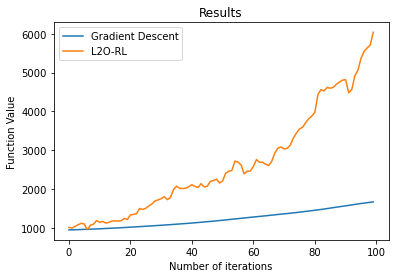

In [26]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()

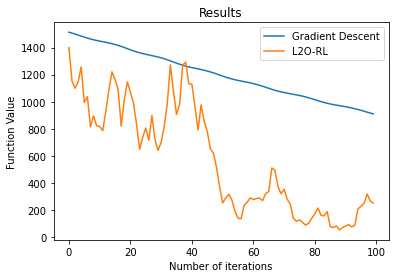

In [28]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()

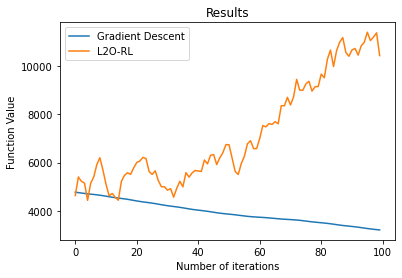

In [30]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()

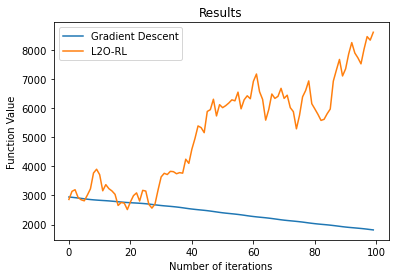

In [33]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()

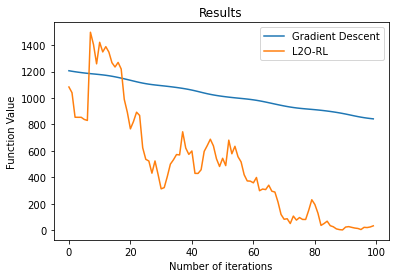

In [35]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()

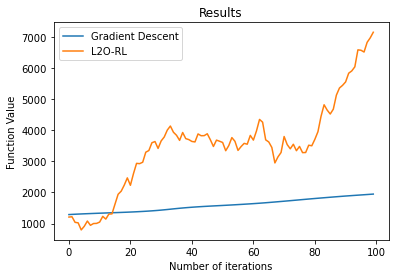

In [37]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()

In [32]:
iteration = 100
lr = 0.003

## Evaluataion
val_gd = []
val_rl = []

env.reset()

A, B, C = env.A, env.B, env.C #A,B,C values
xyz_int = np.random.uniform(env.init_low, env.init_high, env.n)
xyz_rl = xyz_int
xyz_gd = xyz_int

grad = grad_ras(xyz_int, A, B, C)

test_dq = deque(np.zeros(env.dim, dtype = np.float32))
for i in range(env.n):
    test_dq.pop()
test_dq.extendleft(np.flip(grad))
#test_dq.extendleft(np.flip(xyz_int))
        
observation = np.array(test_dq, dtype = np.float32)


for i in range(iteration):
    # gradient descent
    xyz_gd = xyz_gd - lr*grad_ras(xyz_gd, A, B, C)
    val_gd.append(ras(xyz_gd, A, B, C))
    
    # reinforcement learning
    xyz_rl = xyz_rl + model.predict(observation)[0]
    
    grad = grad_ras(xyz_rl, A, B, C)
    for i in range(env.n):
        test_dq.pop()
    test_dq.extendleft(np.flip(grad))
    #test_dq.extendleft(np.flip(xyz_rl))
    
    val_rl.append(ras(xyz_rl, A, B, C))
    

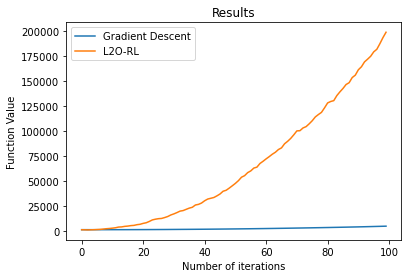

In [31]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()

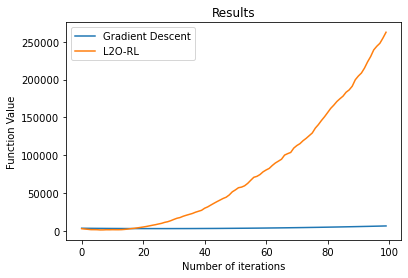

In [33]:
plt.plot(val_gd, label= 'Gradient Descent')
plt.plot(val_rl, label= 'L2O-RL')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Function Value')
plt.title('Results')
plt.show()